# Image Classification Data Collector

#### Project Url: https://github.com/akshath/image_classification_kit_keras

In [36]:
#---- Install stuff -------
#!pip install --upgrade pip

#!pip install opencv-python
#!pip install tensorflow
#!pip install numpy==1.19.5

#!pip install Pillow
#!pip install playsound
#!pip install gTTS
#!pip install pyobjc

#!pip install matplotlib
#!pip install pandas
#!pip install seaborn

#!pip install PyYAML

In [37]:
import os
import time
import random
import shutil

from glob import glob
from pathlib import Path
from datetime import datetime

from gtts import gTTS
from playsound import playsound

from IPython.display import clear_output

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [39]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [40]:
import cv2
from PIL import Image

In [41]:
#print system info
import sys
print('Python: ',sys.version)

Python:  3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]


## Functions

In [42]:
import pycode.FileIOUtil
import pycode.TTSUtil
from pycode.ImageClassificationCfg import ImageClassificationCfg
from pycode.LoadAndTestCNNUtil import LoadAndTestCNNUtil

In [43]:
def get_capture_dim(src_video):
    try:
        cap = cv2.VideoCapture(src_video)
        if(cap.isOpened()):
            ret, frame = cap.read()
            return frame.shape
        else:
            return 0,0
    finally:
        cap.release()
        cv2.destroyAllWindows()

In [44]:
def plot_image(images, captions=None, cmap=None):    
    if captions!=None:
        print(captions)
    
    if len(images) > 1:
        f, axes = plt.subplots(1, len(images), sharey=True, figsize=(4,4))
        f.set_figwidth(15)
        for ax,image in zip(axes, images):
            ax.imshow(image, cmap)
    else:
        plt.figure(figsize=(4,4))
        plt.imshow(images[0])
    plt.show()

In [45]:
def get_file_name():
    return 'img_'+datetime.now().strftime("%Y%m%d%H%M%S")
#get_file_name()

In [46]:
def print_label_select(cfg_file):
    for i in range(len(cfg_file.labels)):
        print(f'[{labels_id[i]}] {cfg_file.labels[i]}')
    sel = input('Select ([d] for del): ')
    return sel

In [47]:
def save_frames(cfg_file, h,w, crop=True, count=1, delay_sec=60):
    cap = None
    if h==0 or w==0:
        raise Exception('h or w can not be 0')
    try:
        cap = cv2.VideoCapture(cfg_file.cfg['src_video'])
        #cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
        
        if(cap.isOpened()):
            for i in range(0, count):
                ret, frame = cap.read()
                if not ret:
                    print("failed to grab frame ")
                    #raise Exception("failed to grab frame ")
                    return None, None

                #print('org shape: ',frame.shape)
                frame = cv2.resize(frame, (w,h), interpolation = cv2.INTER_AREA)

                if crop:
                    if cfg_file.cfg['crop_image_from_left']>0:
                        new_wl = int(w*cfg_file.cfg['crop_image_from_left'])
                    else:
                        new_wl = 0
                        
                    if cfg_file.cfg['crop_image_from_right']>0:
                        #crop 70% on width from right
                        new_wr = int(w*cfg_file.cfg['crop_image_from_right'])
                    else:
                        new_wr = w                    
                        
                    frame = frame[0:h,new_wl:new_wr]

                img_name = cfg_file.loc_unknown+"frame_{0}.png".format(get_file_name())
                cv2.imwrite(img_name, frame)

                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                if count>1:
                    print('file saved: ',img_name)
                    
                if (i+1)!=count:
                    #close and re-open else we will get old frame
                    if cap != None:
                        cap.release()
                    #it take about 2 sec to open cam again
                    if delay_sec>0:
                        time.sleep(delay_sec-2) 
                    cap = cv2.VideoCapture(cfg_file.cfg['src_video'])
                    if(cap.isOpened()==False):
                        print('Could not open camera!')
                        break            
            return frame, img_name
        else:
            print('Could not open camera!')
            return None, None
    finally:
        if cap != None:
            cap.release()
        cv2.destroyAllWindows()

In [48]:
def show_img_and_ask_label(cfg_file, frame, file):
    plt.imshow(frame)
    plt.show()
    
    if cnn is not None:
        (img_class, model_acc) = cnn.predict(file)
        print('Model: {0} [{1}%]\n'.format(img_class,model_acc))
    
    sel = print_label_select(cfg_file)
    sel_array = sel.split(',')
    if sel_array[0] == 'd':
        print('Selected: Delete')
        os.remove(file)
    else:
        for _sel in sel_array:
            sel = int(_sel)
            file_path = Path(file)                
            new_loc = cfg_file.project_data_dir+cfg_file.labels[sel]+'/'+file_path.parts[-1]
            print('Selected: ',cfg_file.labels[sel])
            #print(new_loc)
            shutil.copy2(file, new_loc)
        os.remove(file)

In [49]:
def collect_image(cfg_file, count=1, delay_sec=60, collect_label=True):
    if count==0:
        print('min count is 1')
        return
    
    frame, file = save_frames(cfg_file, img_h, img_w, crop=True, count=count, delay_sec=delay_sec)
    
    if count>1 or collect_label==False:
        return frame, file
    
    if file!=None:
        show_img_and_ask_label(cfg_file, frame, file)
 
    return frame, file

In [50]:
def label_non_labeled(cfg_file):
    all_images = glob(cfg_file.loc_unknown+cfg_file.cfg['file_ext'])
    if len(all_images)==0:
        print('Non labled folder is empty!')
    for file in all_images:
        clear_output(wait=True)

        print('file: ',file)    
        frame = Image.open(file)
        show_img_and_ask_label(cfg_file, frame, file)

In [51]:
#take pic at time set
def take_pics_bw_time(trigger_from, trigger_to, sleep_time_bw_pic = 5, skip_if_size_diff_less_than=-1):
    print('Taking pics from: ',trigger_from,' to: ',trigger_to)
    last_file_size = 0
    while True:
        try:
            time_now = int(datetime.now().strftime("%H%M"))
            
            if time_now>=trigger_from and time_now<=trigger_to:
                last_frame, file = collect_image(cfg_file, count=1, delay_sec=0, collect_label=False)
                if file != None:
                    file_size = FileIOUtil.get_file_size(file)
                    #print('file saved: ',file,', size: ',file_size,'kb')
                    if skip_if_size_diff_less_than > -1:
                        diff = abs(last_file_size - file_size)
                        if diff < skip_if_size_diff_less_than:
                            print('deleting '+file,', size: ',file_size,'kb')
                            os.remove(file)
                        else:
                            print('file saved: ',file,', size: ',file_size,'kb')
                    else:
                        print('file saved: ',file,', size: ',file_size,'kb')
                    last_file_size = file_size

                time.sleep(sleep_time_bw_pic)
            else:
                time.sleep(60)
        except KeyboardInterrupt:
            print('Stopping..')
            break

In [52]:
#img stats functions

In [53]:
def get_label_stats(label, cfg_file, show_image=True):
    dir_loc = cfg_file.project_data_dir+label+'/'
    all_images = glob(dir_loc+cfg_file.cfg['file_ext'])
    int_len = len(all_images)
    
    str_len = str(len(all_images))
    caption = 'Class: '+label.ljust(20, ' ')+'Count: '+str_len.rjust(3,' ')
    
    if show_image:
        rand_img = []
        max_rand = 5 if int_len>=5 else int_len

        if int_len!=0:
            for i in range(max_rand):
                if(int_len>0):
                    frame = Image.open(random.choice(all_images))
                else:
                    frame = Image.open(random.choice(i))
                rand_img.append(frame)
            plot_image(rand_img, caption)
    else:
        pass
        #print(caption)
    return int_len

In [54]:
#_ = get_label_stats(labels[0], show_image=True, file_ext='*.png')

In [55]:
#print image count stats
import sys

def print_img_stats(cfg_file, show_image=True):
    total_img = 0
    class_mis_df = pd.DataFrame(columns=['Class','Count'])
    for i,label in enumerate(cfg_file.labels):
        count = get_label_stats(label, cfg_file, show_image=show_image)
        total_img += count
        
        row = {'Class':label, 'Count':count}
        class_mis_df = class_mis_df[class_mis_df['Class']!=row['Class']] #check to prevent duplicate on re-run
        class_mis_df = class_mis_df.append(row, ignore_index=True) 
    return class_mis_df

In [56]:
#print 1 random images per class from all class
def show_1image_per_class(cfg_file):
    plt.figure(figsize=(14, 14))
    for i,label in enumerate(cfg_file.labels):
        ax = plt.subplot(3, 3, i + 1)

        dir_loc = cfg_file.project_data_dir+label+'/'
        all_images = glob(dir_loc+cfg_file.cfg['file_ext'])

        if len(all_images)!=0:
            frame = Image.open(random.choice(all_images))
            plt.imshow(frame)
        else:
            #plt.imshow(None)
            pass        
        plt.title(label)

        plt.axis("off")

In [57]:
def plot_image_stats():
    print('Total Images: ',class_mis_df.Count.sum())
    print('')
    plt.figure(figsize=(8,4))
    sns.barplot(data=class_mis_df, y='Class', x='Count')
    plt.show()

# Read Cfg

In [58]:
#refer to config_template.yml for example of how it should be

cfg_file = './project/flowers-recognition/cfg.yml'
#cfg_file = './project/work_pose/cfg.yml'
#cfg_file = './project/home_presence/cfg.yml'

cfg_file = ImageClassificationCfg(cfg_file)
cfg_file.load()

In [59]:
cfg_file.log_info()

project_name:  flowers-recognition
--------------------
project_parent_dir:  ./project/
temp_dir:  ./temp/
file_ext:  *.jpg
--------------------
reduce_image_wh_by:  3
crop_image_from_left:  0.0
crop_image_from_right:  0.0
--------------------
project_dir:  ./project/flowers-recognition/
project_temp_dir: ./temp/flowers-recognition/
loc_unknown: ./temp/flowers-recognition/non-labeled/
--------------------
labels_from_dir:  False
label count:  5
labels: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [60]:
#org shape 1080, 1920
capture_dim = get_capture_dim(cfg_file.cfg['src_video'])
print('org dim: ',capture_dim)

img_h = capture_dim[0]
img_w = capture_dim[1]

img_h = img_h//cfg_file.cfg['reduce_image_wh_by']
img_w = img_w//cfg_file.cfg['reduce_image_wh_by']

print('new dim h:',img_h)
print('new dim w:',img_w)

org dim:  (576, 1024, 3)
new dim h: 192
new dim w: 341


In [61]:
#!ls $project_data_dir
pycode.FileIOUtil.print_dir(cfg_file.project_data_dir, only_dir=True)

./project/flowers-recognition//data/daisy
./project/flowers-recognition//data/dandelion
./project/flowers-recognition//data/rose
./project/flowers-recognition//data/sunflower
./project/flowers-recognition//data/tulip


In [62]:
if cfg_file.cfg['labels_from_dir']==False:
    if os.path.isdir(cfg_file.project_dir)==False:
        os.mkdir(cfg_file.project_dir)
    if os.path.isdir(cfg_file.project_data_dir)==False:
        os.mkdir(cfg_file.project_data_dir)
    #!ls $project_data_dir
    pycode.FileIOUtil.print_dir(cfg_file.project_data_dir, only_dir=True)

    if os.path.isdir(cfg_file.project_temp_dir)==False:
        os.mkdir(cfg_file.project_temp_dir)
    #!ls $project_temp_dir
    pycode.FileIOUtil.print_dir(cfg_file.project_temp_dir, only_dir=True)
else:
    print('We assume dir is alreay there.')

./project/flowers-recognition//data/daisy
./project/flowers-recognition//data/dandelion
./project/flowers-recognition//data/rose
./project/flowers-recognition//data/sunflower
./project/flowers-recognition//data/tulip
./temp/flowers-recognition/non-labeled


In [63]:
if os.path.isdir(cfg_file.project_temp_dir)==False:
    os.mkdir(cfg_file.project_temp_dir)
    
if os.path.isdir(cfg_file.loc_unknown)==False:
    os.mkdir(cfg_file.loc_unknown)
    
for label in cfg_file.labels:
    if os.path.isdir(cfg_file.project_data_dir+label)==False:
        os.mkdir(cfg_file.project_data_dir+label)

In [64]:
labels_id = [x for x in range(0,len(cfg_file.labels))]
print(labels_id)

[0, 1, 2, 3, 4]


In [65]:
#if model file is there.. lets load it
if cfg_file.cfg['model_file'] != '':
    if os.path.isfile(cfg_file.cfg['model_file']):
        cnn = LoadAndTestCNNUtil(cfg_file)
        cnn.debug = False
        cnn.load()
    else:
        cnn = None
else:
    cnn = None

# Collect Data

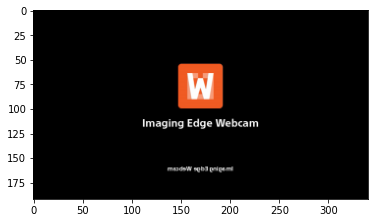

[0] daisy
[1] dandelion
[2] rose
[3] sunflower
[4] tulip


Select ([d] for del):  d


Selected: Delete


In [66]:
collect_data_type = 5

if collect_data_type == 1:
    #pick 1 quick image and label it
    last_frame, file = collect_image(cfg_file, count=1, delay_sec=60)
    #print(last_frame.shape)
elif collect_data_type == 2:
    #pick 20 quick image every 
    #2m - 120, 30img = 60m = 1h, 
    #5m - 300, 20img = 1.6h
    #10m = 600, 20img = 3.3h
    #15m - 900, 20 img = 5h
    try:
        last_frame, file = collect_image(cfg_file, count=40, delay_sec=120)
    except KeyboardInterrupt: 
        print('Stopping..')
elif collect_data_type == 3:
    #pick 60 quick image every 2sec = 2m captured
    try:
        last_frame, file = collect_image(cfg_file, count=120, delay_sec=3)
    except KeyboardInterrupt:
        print('Stopping..')
elif collect_data_type == 4:
    #take pics b/w time windows, at 5sec interval. save only if size diff is over 2kb
    #take_pics_bw_time(trigger_from=1730, trigger_to=1830, sleep_time_bw_pic = 5, skip_if_size_diff_less_than=3)
    take_pics_bw_time(trigger_from=630, trigger_to=930, sleep_time_bw_pic = 5, skip_if_size_diff_less_than=3)
    #take_pics_bw_time(trigger_from=1700, trigger_to=1830, sleep_time_bw_pic = 5, skip_if_size_diff_less_than=3)
elif collect_data_type == 5:
    #label all non labeled images
    label_non_labeled(cfg_file)
else:
    print('Nothing to do!')

# Data Stats

In [67]:
class_mis_df = print_img_stats(cfg_file, show_image=False)
class_mis_df

,Class,Count
0,daisy,1
1,dandelion,1
2,rose,1
3,sunflower,1
4,tulip,1


Total Images:  5



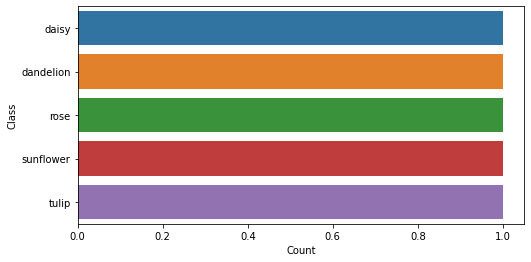

In [68]:
plot_image_stats()

Class: daisy               Count:   1


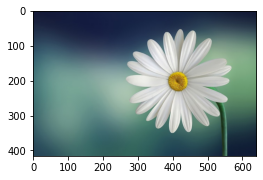

Class: dandelion           Count:   1


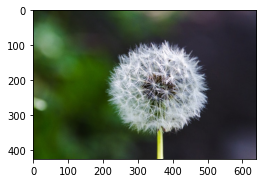

Class: rose                Count:   1


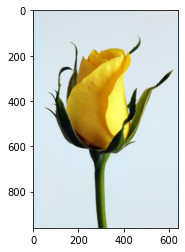

Class: sunflower           Count:   1


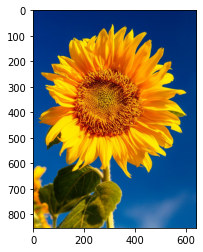

Class: tulip               Count:   1


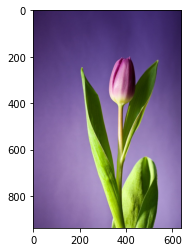

In [69]:
_ = print_img_stats(cfg_file, show_image=True)

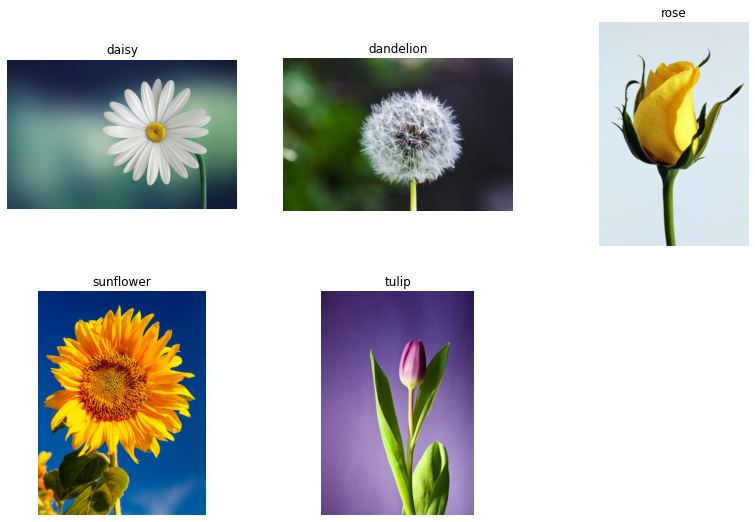

In [70]:
show_1image_per_class(cfg_file)